<a href="https://colab.research.google.com/github/jrobledob/AI_in_Plant_Pathology_Fall_2025/blob/main/Logistic_Regression_for_Plant_Pathologists.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Logistic Regression for Plant Pathologists 🌱

**Goal:** give an intuitive, hands-on understanding of logistic regression to answer practical plant pathology questions such as:

- “Given field/lab measurements, what’s the probability a plant is **diseased (1)** vs **healthy (0)**?”  
- “How do I interpret coefficients, probabilities, and thresholds?”  
- “How do I evaluate model performance (confusion matrix, ROC–AUC, precision–recall)?”

We’ll keep the math to what is most useful in practice, with visuals you can reuse in your own analyses.



## What you’ll learn

- The **sigmoid** function: how logistic regression turns any number into a probability between 0 and 1.  
- The **loss (cross-entropy)** and why it punishes wrong, over-confident predictions.  
- Training with **gradient descent (intuition)** and with scikit-learn’s reliable solvers.  
- Visualizing **decision boundaries** and **probability maps**.  
- Practical **evaluation**: confusion matrix, ROC–AUC, precision–recall, calibration.  
- Handling **class imbalance** and **regularization** (to avoid overfitting).  
- Quick look at **multiclass** logistic regression.


## Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score, RocCurveDisplay,
                             PrecisionRecallDisplay, brier_score_loss)
from sklearn.calibration import calibration_curve
plt.style.use("bmh")
np.random.seed(42)
print("Ready!")

Ready!



## 1) The sigmoid: turning a score into a probability

Logistic regression computes a **score** $z = \mathbf{w}^\top \mathbf{x} + w_0$ from your features $\mathbf{x}$ (e.g., lab/field measurements) and then maps $z$ into a probability with the **sigmoid**:

$$
\sigma(z) = \frac{1}{1 + e^{-z}} \in (0,1)
$$

- If $z$ is large and positive → probability close to **1** (likely diseased).  
- If $z$ is large and negative → probability close to **0** (likely healthy).  
- When $z = 0$, probability is **0.5**.


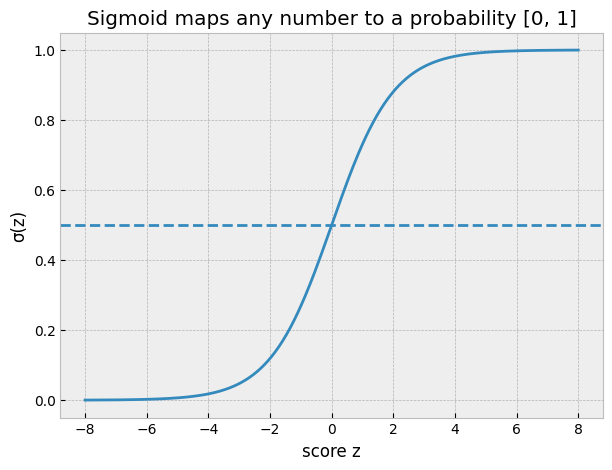

In [4]:

z = np.linspace(-8, 8, 400)
sig = 1/(1+np.exp(-z))

plt.figure(figsize=(7,5))
plt.plot(z, sig)
plt.axhline(0.5, linestyle="--")
plt.xlabel("score z")
plt.ylabel("σ(z)")
plt.title("Sigmoid maps any number to a probability [0, 1]")
plt.show()



## 2) Loss (cross-entropy): encouraging well-calibrated probabilities

If the true label is **1** (diseased), we want the predicted probability **high**; if it’s **0** (healthy), we want it **low**.  
The **cross-entropy** loss does exactly that:

$$
J = -\big[t \log(p) + (1-t)\log(1-p)\big]
$$

- When we’re **correct and confident**, the loss is **near 0**.  
- When we’re **confident but wrong**, the loss becomes **very large** (strong penalty).


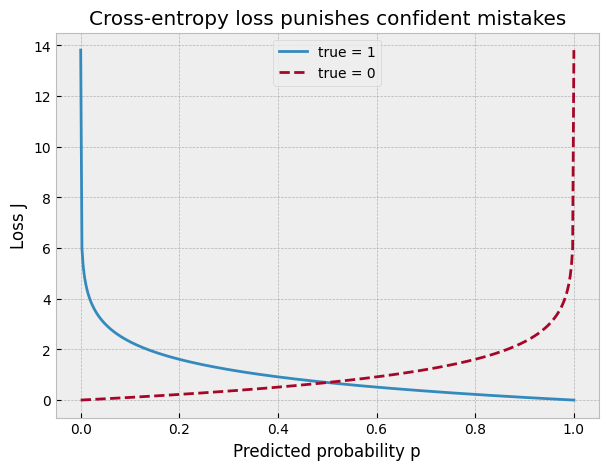

In [5]:

p = np.linspace(1e-6, 1-1e-6, 400)  # avoid log(0)
loss_t1 = -np.log(p)          # true = 1
loss_t0 = -np.log(1-p)        # true = 0

plt.figure(figsize=(7,5))
plt.plot(p, loss_t1, label="true = 1")
plt.plot(p, loss_t0, linestyle="--", label="true = 0")
plt.xlabel("Predicted probability p")
plt.ylabel("Loss J")
plt.title("Cross-entropy loss punishes confident mistakes")
plt.legend()
plt.show()



## 3) Training (intuition): gradient descent

We adjust the weights $\mathbf{w}$ to **reduce the loss**. Gradient descent moves parameters in small steps **downhill** (toward lower loss).  
In practice, you’ll often use scikit-learn’s solvers (like **lbfgs**) which are fast and robust.



## 4) A tiny example (2 features → easy visuals)

We'll use two features from the classic Iris dataset, just so we can **see** the decision boundary in 2D.  
Think of them as two field measurements (e.g., lesion length and width).

- We’ll create a **binary** problem: *setosa* $=1$ (positive) vs *not-setosa* $=0$ (negative).
- Then we’ll compare a simple **gradient-descent** implementation (for learning) vs scikit-learn’s **LogisticRegression** (for real work).


In [6]:

iris = load_iris()
X = iris.data[:, 2:4].copy()       # two features for plotting
y = (iris.target == 0).astype(int) # setosa vs not-setosa

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shapes:", X.shape, y.shape)


Shapes: (150, 2) (150,)


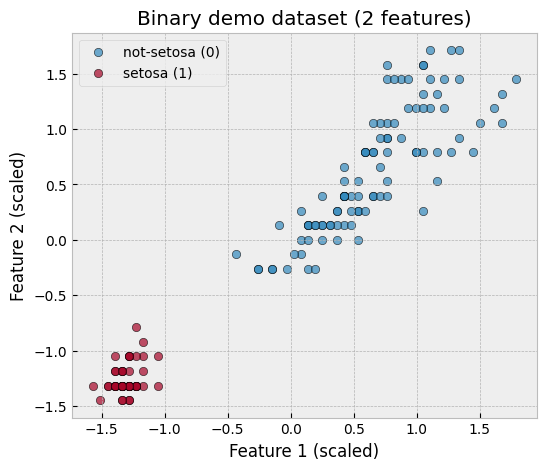

In [7]:

plt.figure(figsize=(6,5))
plt.scatter(X_scaled[y==0,0], X_scaled[y==0,1], edgecolors='k', alpha=0.7, label='not-setosa (0)')
plt.scatter(X_scaled[y==1,0], X_scaled[y==1,1], edgecolors='k', alpha=0.7, label='setosa (1)')
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.legend()
plt.title("Binary demo dataset (2 features)")
plt.show()



### Simple gradient descent logistic regression (for learning)

We use $p = \sigma(z)$ where $z = w_0 + \mathbf{w}^\top\mathbf{x}$ and minimize the cross-entropy $J$.  
(Use scikit-learn for your real analyses.)


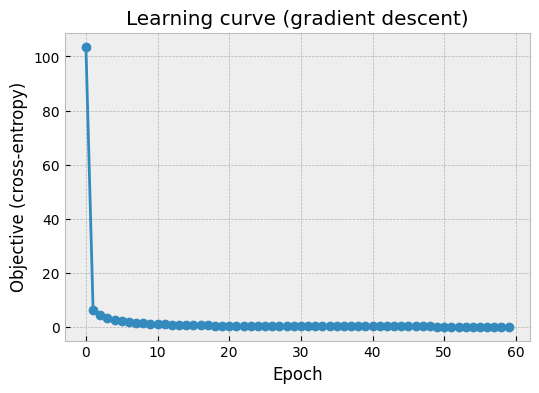

array([-6.3064988 , -5.76853493, -5.51252229])

In [8]:

def sigmoid(z):
    return 1/(1+np.exp(-z))

def fit_logreg_gd(X, t, eta=0.1, n_epochs=50, random_state=1, visualize=True):
    rng = np.random.RandomState(random_state)
    w = rng.normal(0, 0.01, size=1 + X.shape[1])  # [w0, w1, w2]
    cost_hist = []

    for epoch in range(n_epochs):
        z = w[0] + X @ w[1:]
        p = sigmoid(z)
        # cross-entropy
        cost = -(t*np.log(p + 1e-12) + (1-t)*np.log(1-p + 1e-12)).sum()
        cost_hist.append(cost)
        # gradient
        error = t - p
        w[1:] += eta * (X.T @ error)
        w[0]  += eta * error.sum()

    # Plot learning curve
    if visualize:
        plt.figure(figsize=(6,4))
        plt.plot(cost_hist, marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Objective (cross-entropy)")
        plt.title("Learning curve (gradient descent)")
        plt.show()

    return w, cost_hist

w_gd, cost_hist = fit_logreg_gd(X_scaled, y, eta=0.1, n_epochs=60, visualize=True)
w_gd


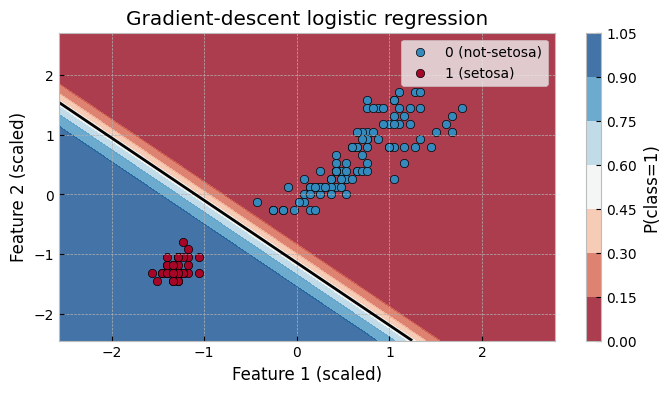

In [9]:

def plot_prob_map(X, y, w, title="Probability map & decision boundary"):
    # grid
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    p = sigmoid(w[0] + grid @ w[1:]).reshape(xx.shape)

    plt.figure(figsize=(8,4))
    cs = plt.contourf(xx, yy, p, alpha=0.8, cmap=plt.cm.RdBu)
    plt.colorbar(cs, label="P(class=1)")
    plt.scatter(X[y==0,0], X[y==0,1], edgecolors='k', label='0 (not-setosa)')
    plt.scatter(X[y==1,0], X[y==1,1], edgecolors='k', label='1 (setosa)')
    plt.contour(xx, yy, p, levels=[0.5], colors="k", linewidths=2)
    plt.legend(loc="upper right")
    plt.title(title)
    plt.xlabel("Feature 1 (scaled)")
    plt.ylabel("Feature 2 (scaled)")
    plt.show()

plot_prob_map(X_scaled, y, w_gd, title="Gradient-descent logistic regression")



## 5) Training with scikit-learn (recommended)

scikit-learn’s `LogisticRegression` uses reliable optimization under the hood (default: **lbfgs**).  
We’ll also split into **train/test**, evaluate and plot common metrics.


In [10]:

Xtr, Xte, ytr, yte = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

clf = LogisticRegression(penalty=None, solver="lbfgs", max_iter=500, random_state=42)
clf.fit(Xtr, ytr)
print("Train acc:", clf.score(Xtr, ytr))
print("Test  acc:", clf.score(Xte, yte))
print("Intercept:", clf.intercept_)
print("Coeffs:", clf.coef_)


Train acc: 1.0
Test  acc: 1.0
Intercept: [-8.38139688]
Coeffs: [[-8.39450843 -5.24106522]]


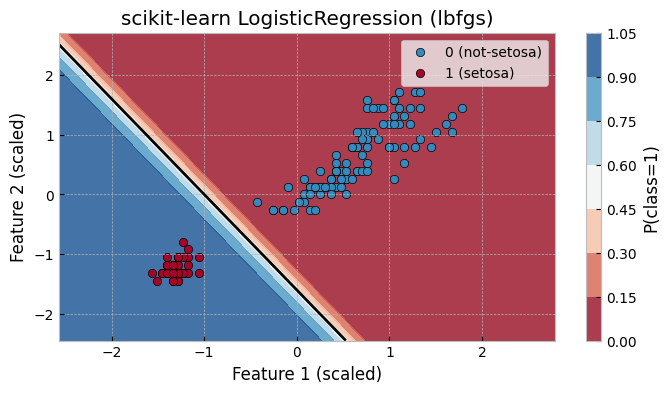

In [11]:

w_skl = np.r_[clf.intercept_[0], clf.coef_[0]]
plot_prob_map(X_scaled, y, w_skl, title="scikit-learn LogisticRegression (lbfgs)")



## 6) Model evaluation that matters in plant pathology

- **Confusion matrix**: counts of TP/FP/TN/FN (helps plan confirmatory testing).  
- **ROC–AUC**: ranking quality across thresholds (good for overall discrimination).  
- **Precision–Recall**: useful when positives are **rare**.  
- **Calibration**: do predicted probabilities match observed frequencies?

Probability is $p = \Pr(y=1\mid \mathbf{x})$; a common **threshold** is $0.5$, but you should adjust it to your decision costs.


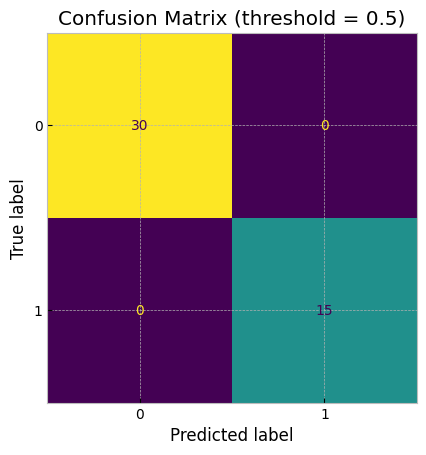

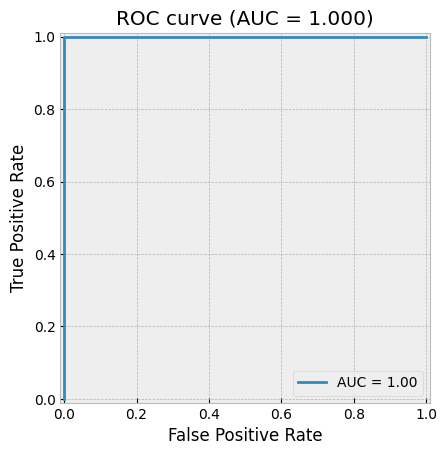

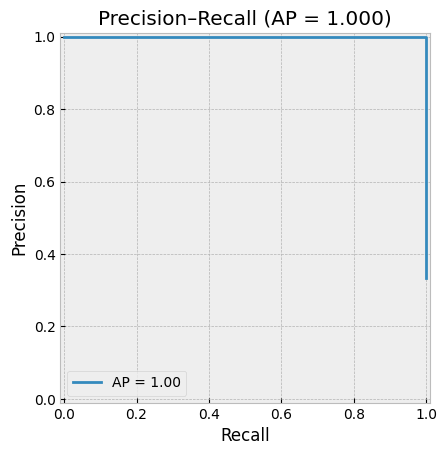

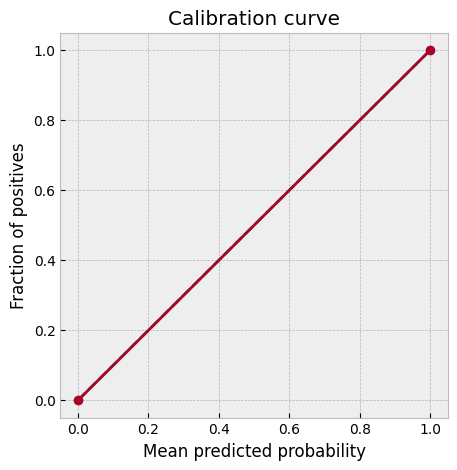

Brier score (lower is better): 6.365804233580132e-06


In [12]:

yproba_te = clf.predict_proba(Xte)[:,1]
ypred_te  = (yproba_te >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(yte, ypred_te, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(colorbar=False)
plt.title("Confusion Matrix (threshold = 0.5)")
plt.show()

# ROC
fpr, tpr, _ = roc_curve(yte, yproba_te)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title(f"ROC curve (AUC = {roc_auc:.3f})")
plt.show()

# Precision–Recall
prec, rec, _ = precision_recall_curve(yte, yproba_te)
ap = average_precision_score(yte, yproba_te)
PrecisionRecallDisplay(precision=prec, recall=rec, average_precision=ap).plot()
plt.title(f"Precision–Recall (AP = {ap:.3f})")
plt.show()

# Calibration
prob_true, prob_pred = calibration_curve(yte, yproba_te, n_bins=5, strategy="uniform")
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1], linestyle="--")
plt.plot(prob_pred, prob_true, marker="o")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve")
plt.show()

print("Brier score (lower is better):", brier_score_loss(yte, yproba_te))



### Choosing a threshold that matches your goal

- If you want **few false negatives** (don’t miss disease), use a **lower** threshold (e.g., $0.3$).  
- If you want **few false positives** (avoid overreacting), use a **higher** threshold (e.g., $0.7$).

Tune the threshold using validation data and your cost/benefit trade-offs.



## 7) Class imbalance & regularization

- **Imbalance**: when positives are rare, set `class_weight='balanced'` or provide custom weights.  
- **Regularization**: prevents overfitting; L2 adds a penalty $\lambda \lVert \mathbf{w} \rVert_2^2$ controlled by `C` (smaller `C` = stronger regularization).


In [13]:

# Example: using class_weight and L2 regularization
clf_bal = LogisticRegression(penalty="l2", C=1.0, class_weight="balanced",
                             solver="lbfgs", max_iter=500, random_state=42)
clf_bal.fit(Xtr, ytr)
print("Balanced model - Test acc:", clf_bal.score(Xte, yte))


Balanced model - Test acc: 1.0



## 8) Multiclass logistic regression (quick look)

When there are **more than two** classes (e.g., *species A*, *B*, *C* or **symptom categories**), logistic regression extends naturally using **softmax**:

$$
p(y=k\mid \mathbf{x}) = \frac{\exp(\mathbf{w}_k^\top \mathbf{x} + w_{0,k})}{\sum_{j} \exp(\mathbf{w}_j^\top \mathbf{x} + w_{0,j})}
$$


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


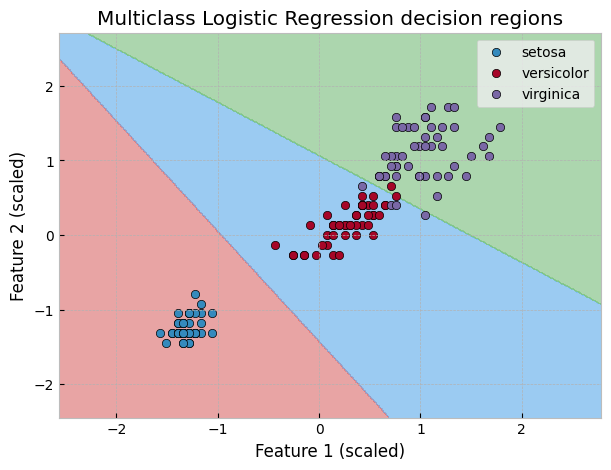

In [14]:

X_multi = iris.data[:, 2:4].copy()
y_multi = iris.target.copy()
X_multi_scaled = StandardScaler().fit_transform(X_multi)

clf_multi = LogisticRegression(multi_class="multinomial", penalty="l2",
                               C=1.0, solver="lbfgs", max_iter=500, random_state=42)
clf_multi.fit(X_multi_scaled, y_multi)

# Decision regions
x_min, x_max = X_multi_scaled[:,0].min()-1, X_multi_scaled[:,0].max()+1
y_min, y_max = X_multi_scaled[:,1].min()-1, X_multi_scaled[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
pred = clf_multi.predict(grid).reshape(xx.shape)

plt.figure(figsize=(7,5))
cmap = ListedColormap(["#E57373","#64B5F6","#81C784"])
plt.contourf(xx, yy, pred, alpha=0.6, cmap=cmap)
for k, name in enumerate(iris.target_names):
    plt.scatter(X_multi_scaled[y_multi==k,0],
                X_multi_scaled[y_multi==k,1],
                edgecolors='k', label=name)
plt.legend()
plt.title("Multiclass Logistic Regression decision regions")
plt.xlabel("Feature 1 (scaled)"); plt.ylabel("Feature 2 (scaled)")
plt.show()



## 9) Practical checklist for plant pathology projects ✅

- **Define the question** clearly (screening vs confirmation → threshold choice).  
- **Split** train/test (and ideally use cross-validation).  
- **Scale** features if magnitudes vary widely.  
- Watch **class imbalance** → use `class_weight` or resampling.  
- Inspect **confusion matrix**, **ROC–AUC**, **PR** and **calibration**.  
- Use **regularization** (`penalty`, `C`) to avoid overfitting.  
- Prefer **scikit-learn** for robust fitting; custom GD only for teaching/demos.  
- Communicate **probabilities**, not just labels; align with decision costs in the field/lab.
